# 1. 라이브러리 로드

In [1]:
import os

import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib import rc
sns.set_style("darkgrid")
rc('font', family='NanumGothic')  # 예: 나눔고딕 사용
plt.rcParams['axes.unicode_minus'] = False  # 음수 기호 깨짐 방지

import warnings
warnings.filterwarnings('ignore')

# 2. 데이터 로드

In [2]:
news_files = [pd.read_csv(f'news_dataset/{file_name}', index_col=0) for file_name in os.listdir('news_dataset')]
news_df = pd.concat(news_files, ignore_index=True)

In [3]:
# 분석 대상 기간인 2010년 6월부터 가져옴
news_df['yyyymm'] = news_df['date'].map(lambda x: x.replace('.', '-')[:7] + '-01')
news_df = news_df.query("yyyymm >= '2010-01-01' and yyyymm <= '2024-09-01'")

news_df['yyyymm'].min(), news_df['yyyymm'].max()

('2010-06-01', '2024-09-01')

In [4]:
news_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21996 entries, 16 to 22180
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        21996 non-null  object
 1   link         21996 non-null  object
 2   article      21732 non-null  object
 3   date         21996 non-null  object
 4   media        21996 non-null  object
 5   region_code  21996 non-null  int64 
 6   region       21996 non-null  object
 7   yyyymm       21996 non-null  object
dtypes: int64(1), object(7)
memory usage: 1.5+ MB


In [5]:
# 생활권역 컬럼 추가
# https://urban.seoul.go.kr/view/html/PMNU2030000000

# 매핑 딕셔너리 생성
district_mapping = {
    '종로구': '도심권', '중구': '도심권', '용산구': '도심권',

    '성동구': '동북권', '동대문구': '동북권', '성북구': '동북권', '도봉구': '동북권',
    '광진구': '동북권', '중랑구': '동북권', '강북구': '동북권', '노원구': '동북권',

    '은평구': '서북권', '서대문구': '서북권', '마포구': '서북권',

    '양천구': '서남권', '영등포구': '서남권', '강서구': '서남권', '동작구': '서남권',
    '관악구': '서남권', '금천구': '서남권', '구로구': '서남권',
    
    '서초구': '동남권', '강남구': '동남권', '송파구': '동남권', '강동구': '동남권'
}

# apply 메소드에서 사용될 함수
def map_to_life_zone(district):
    return district_mapping.get(district, '알 수 없음')

news_df['district'] = news_df['region'].map(map_to_life_zone)
news_df['district'].value_counts()

district
동남권    5464
서남권    5038
도심권    4839
동북권    4551
서북권    2104
Name: count, dtype: int64

In [6]:
# 뉴스기사 원문 미존재 데이터 제거
news_df = news_df.dropna(subset='article')
news_df['article'] = news_df['article'].astype(str)
news_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21732 entries, 16 to 22180
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        21732 non-null  object
 1   link         21732 non-null  object
 2   article      21732 non-null  object
 3   date         21732 non-null  object
 4   media        21732 non-null  object
 5   region_code  21732 non-null  int64 
 6   region       21732 non-null  object
 7   yyyymm       21732 non-null  object
 8   district     21732 non-null  object
dtypes: int64(1), object(8)
memory usage: 1.7+ MB


In [7]:
# 뉴스 기사 제목이 동일한 경우, 중복 제거
# 동일한 제목을 가진 기사 중 먼저 등장한 기사를 선정
news_df = news_df.drop_duplicates(subset='title').reset_index(drop=True)
news_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20428 entries, 0 to 20427
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        20428 non-null  object
 1   link         20428 non-null  object
 2   article      20428 non-null  object
 3   date         20428 non-null  object
 4   media        20428 non-null  object
 5   region_code  20428 non-null  int64 
 6   region       20428 non-null  object
 7   yyyymm       20428 non-null  object
 8   district     20428 non-null  object
dtypes: int64(1), object(8)
memory usage: 1.4+ MB


In [8]:
# 뉴스 기사 제목 또는 원문 내 행정구 명이 존재하는 경우에만 해당 기사 가져옴
# 단, 중구의 경우 대전을 포함하는 원문 제외 (대전 중구가 따로 존재)
refined_news_df_list = []
for region in news_df['region'].unique():

    if region == '중구':
        single_refined_news_df = news_df[(news_df["region"] == region) & ((news_df['title'].str.contains(region[:2])) | (news_df['article'].str.contains(region[:2]))) & (~news_df['article'].str.contains('대전'))]

    else:
        single_refined_news_df = news_df[(news_df["region"] == region) & ((news_df['title'].str.contains(region[:2])) | (news_df['article'].str.contains(region[:2])))]

    refined_news_df_list.append(single_refined_news_df)

refined_news_df = pd.concat(refined_news_df_list, ignore_index=True)
refined_news_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17075 entries, 0 to 17074
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        17075 non-null  object
 1   link         17075 non-null  object
 2   article      17075 non-null  object
 3   date         17075 non-null  object
 4   media        17075 non-null  object
 5   region_code  17075 non-null  int64 
 6   region       17075 non-null  object
 7   yyyymm       17075 non-null  object
 8   district     17075 non-null  object
dtypes: int64(1), object(8)
memory usage: 1.2+ MB


In [9]:
origin_news_groupby_region_df = news_df.groupby(['region']).nunique()[['article']].reset_index().sort_values('article', ascending=False)
refined_news_groupby_region_df = refined_news_df.groupby(['region']).nunique()[['article']].reset_index().sort_values('article', ascending=False)

compare_df = origin_news_groupby_region_df.merge(refined_news_groupby_region_df, on='region')
compare_df['diff'] = compare_df['article_x'] - compare_df['article_y']

compare_df.sort_values('diff', ascending=False)

,region,article_x,article_y,diff
0,중구,2418,821,1597
2,송파구,1147,921,226
5,종로구,925,715,210
1,강남구,2119,1940,179
9,마포구,786,652,134
4,서초구,934,819,115
7,강서구,868,754,114
6,영등포구,869,759,110
3,용산구,1130,1047,83
15,서대문구,593,521,72


In [9]:
len(set(news_df.query("region == '용산구'")['title'].tolist()) - set(refined_news_df.query("region == '용산구'")['title'].tolist()))

83

In [10]:
# # 최종 뉴스데이터 파일 생성
# news_df.to_csv('district_news_data.csv', encoding='utf-8-sig')
# refined_news_df.to_csv('refined_news.csv', encoding='utf-8-sig')

# 3. EDA
* 수집 기간: 2010년 6월 ~ 2024년 9월

* EDA 항목
    * 각 행정구 별 뉴스 기사 수
    * 각 생활권역별 뉴스 기사 수
    * 각 생활권역별 월별 뉴스 기사 수

* EDA 결과
    * 중구의 경우, 서울시를 대표하는 부동산 관련 뉴스가 모두 포함됨 => 가장 많은 뉴스 기사를 가진 행정구로 등장한 이유
    * 중구에 대하여 뉴스 기사 제목 또는 원문에 중구 포함 여부를 탐색하는 조건 필요
    * 대전 중구에 관한 기사도 제거 필요

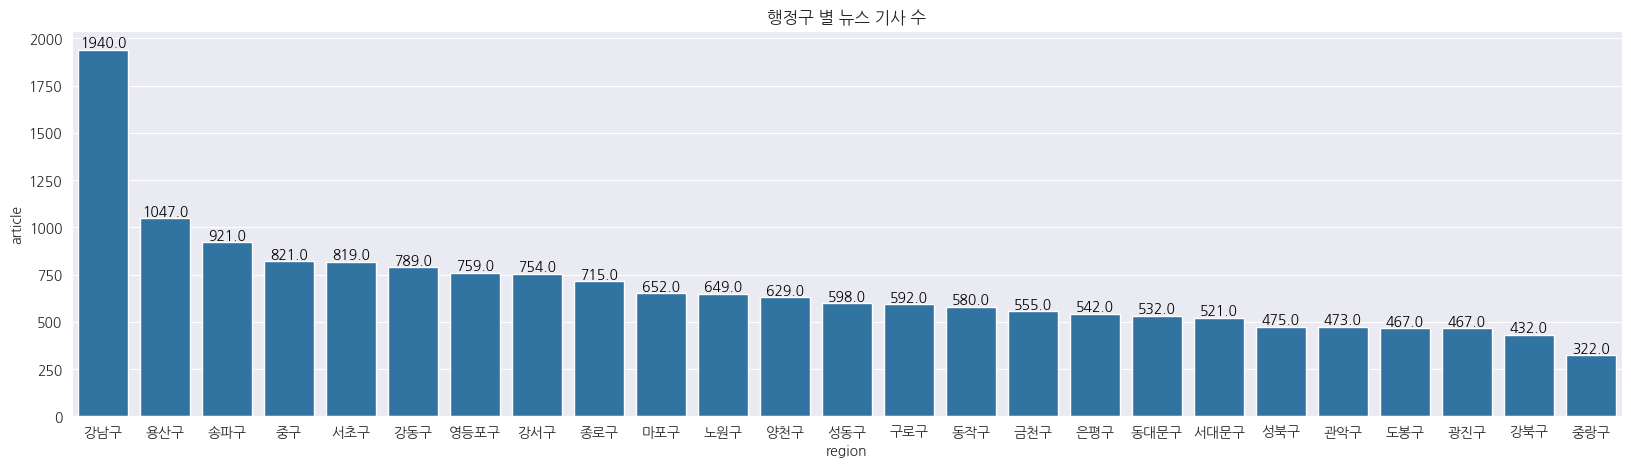

In [11]:
# 각 행정구 별 뉴스 기사 수
news_df_groupby_region = refined_news_df.groupby(['region']).nunique()[['article']].reset_index().sort_values('article', ascending=False)

plt.figure(figsize=(20, 5))
plt.title('행정구 별 뉴스 기사 수')

groupby_region_ax = sns.barplot(data=news_df_groupby_region, x='region', y='article')

for i, bar in enumerate(groupby_region_ax.patches):  # 각 바에 접근
    value = bar.get_height()  # 바의 높이(값) 가져오기
    groupby_region_ax.text(  # 텍스트 추가
        bar.get_x() + bar.get_width() / 2,  # 바의 중심
        value,  # 바의 높이 위에 표시
        f'{value:.1f}',  # 텍스트 형식
        ha='center',  # 수평 정렬
        va='bottom',  # 수직 정렬
        fontsize=10,  # 폰트 크기
        color='black'  # 텍스트 색상
    )

plt.show()

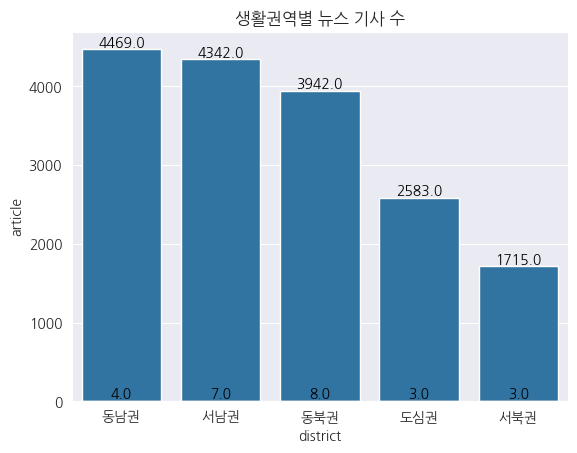

In [12]:
# 각 생활권역별 뉴스 기사 수
news_df_groupby_district = refined_news_df.groupby(['district']).nunique()[['region', 'article']].reset_index().sort_values('article', ascending=False)

plt.title('생활권역별 뉴스 기사 수')

groupby_district_ax = sns.barplot(data=news_df_groupby_district, x='district', y='article')
sns.barplot(data=news_df_groupby_district, x='district', y='region')

for i, bar in enumerate(groupby_district_ax.patches):  # 각 바에 접근
    value = bar.get_height()  # 바의 높이(값) 가져오기
    groupby_district_ax.text(  # 텍스트 추가
        bar.get_x() + bar.get_width() / 2,  # 바의 중심
        value,  # 바의 높이 위에 표시
        f'{value:.1f}',  # 텍스트 형식
        ha='center',  # 수평 정렬
        va='bottom',  # 수직 정렬
        fontsize=10,  # 폰트 크기
        color='black'  # 텍스트 색상
    )

plt.show()

In [13]:
# 각 생활권역별 월별 뉴스 기사 수
# 2016년 1월부터 모든 생활권역의 뉴스 기사 수가 큰 변화폭이 보이지 않음
news_df_groupby_district_month = refined_news_df.groupby(['district', 'yyyymm']).nunique()['article'].to_frame().reset_index()
news_df_groupby_district_month['yyyymm'] = pd.to_datetime(news_df_groupby_district_month['yyyymm'])

# 생활권역 목록 추출
districts = news_df_groupby_district_month['district'].unique()

# Subplots 생성
fig = make_subplots(
    rows=len(districts), cols=1,  # 각 생활권역을 한 줄씩
    shared_xaxes=True,  # x축 공유
    vertical_spacing=0.05,  # 서브플롯 간 간격
    subplot_titles=districts  # 각 서브플롯의 제목
)

# 각 생활권역별 데이터 추가
for i, district in enumerate(districts):
    district_data = news_df_groupby_district_month[news_df_groupby_district_month['district'] == district]
    fig.add_trace(
        go.Scatter(
            x=district_data['yyyymm'], 
            y=district_data['article'],
            mode='lines+markers',
            name=district
        ),
        row=i + 1, col=1  # 서브플롯 위치
    )

# 레이아웃 조정
fig.update_layout(
    height=300 * len(districts),  # 서브플롯 개수에 따라 높이 조정
    title="생활권역별 월별 뉴스 기사 수",
    xaxis_title="월별",
    yaxis_title="기사 수",
    showlegend=False,  # 각 서브플롯에 개별 범례 표시 안 함
    template="plotly_white"
)

# 그래프 표시
fig.show()